In [1]:
%matplotlib inline

## Import common Python libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

matplotlib.rc("figure", figsize=(8, 6))

colors = cm.tab10(np.linspace(0, 1, 10))

# Logistic function

First, let us define the logistic sigmoid function:

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

Here, you can see how does it look like:

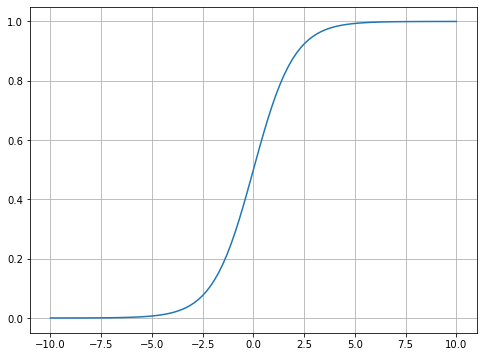

In [3]:
def expit(x):
    return 1 / (1 + np.exp(-x))

plt.plot(np.linspace(-10, 10, 100), expit(np.linspace(-10, 10, 100)))
plt.grid()
plt.show()

Generally speak, the logistic linear regression is to find the best set of parameter ($\mathbf{\beta}$) that fits the data for the following function:

$$
y_i = \frac{1}{1 + e^{-(\sum_{k=0}^K \beta_k x_i)}}
$$

In the following of the example, we will derive the solution with one dimensional input. In this case, the function can be written as:

$$
y_i = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}}
$$

where, $\beta_0$ and $\beta_1$ are the intercept and slop of the linear model. (Hence, the logistic regression is also a type of generalized linear regression)

# Logistic regression in Scikit-Learn

First, let's generate some sample data, with the size of 100.

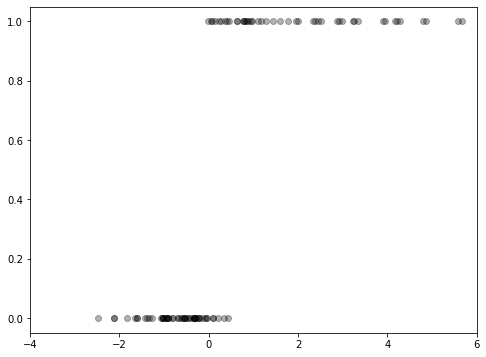

In [4]:
n_samples = 100

# draw data from a nomal distriution
np.random.seed(42)
X = np.random.normal(size=n_samples)

# make y=1 for all x>0
y = (X > 0).astype(np.float)

# make x>0 more spread and shift data to right
X[X > 0] *= 3
X += 0.5*np.random.normal(size=n_samples)
X = X.reshape(-1, 1)

plt.scatter(X, y, alpha=0.3, color="k")
plt.xlim([-4, 6])
plt.show()


Now we can fit the data with Scikit `LogisticRegression()` class.

intercept: -0.747237376124472, slop: 3.0801204039172903


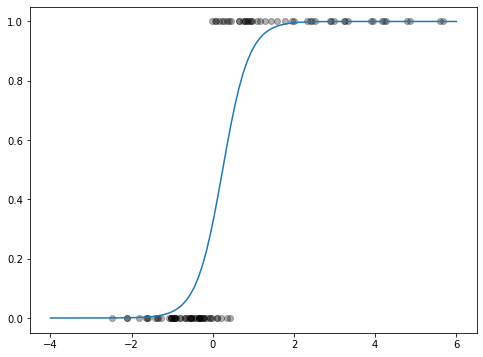

In [5]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X, y)

print("intercept: {}, slop: {}".format(logreg.intercept_[0], logreg.coef_[0][0]))

X_test = np.linspace(-4, 6, 100)
model = expit(X_test * logreg.coef_ + logreg.intercept_).squeeze()

plt.scatter(X, y, alpha=0.3, color="k")
plt.plot(X_test, model, color=colors[0])
plt.show()

# Build your own logistic regressor

We are also interested in understanding how does it work in the background. In the following section, we will derive the (almost) closed form solution for logistic regression with one-dimension input.

Here are some of the key concepts:
- Maximum likelihood estimation
- Log-likelihood
- Non-linear solver


## Probabilistic interpretation of the logistic sigmoid function

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1280px-Logistic-curve.svg.png" style="margin:auto" width=400px />

The logistic sigmoid function, essentially, represents the probabilities of truth given any inputs. So we have the following terms:

\begin{align}
y &= P(y=1) \\
&= \frac{1}{1+e^{-(\beta_0 + \beta_1 x)}}
\end{align}

For simplicity we will use $P(y=1)$ as $P$, so:

\begin{equation}
P = \frac{1}{1+e^{-(\beta_0 + \beta_1 x)}} = \frac{e^{\beta_0 + \beta_1 x}}{1+e^{\beta_0 + \beta_1 x}}
\end{equation}

We can also rearrange this equation to have:

\begin{equation}
\frac{P}{1-P}  = e^{\beta_0 + \beta_1 x}
\end{equation}

and 

\begin{equation}
1 - P = \left( 1 + e^{\beta_0 + \beta_1 x} \right )^{-1}
\end{equation}



These equations will be used later.

## Maximum likelihood estimation (MLE)

Let us represent the data as: $(x_0, y_0), (x_1, y_1), \cdots ,(x_N, y_N)$, with $y_i \in \{0, 1\}$

Since the output $y$ can either be $0$ or $1$, the random variable follows the Bernoulli distribution. The probability density function can be expressed as:

\begin{equation}
f(y_i|\beta) = P_i^{y_i} (1-P_i)^{1-y_i}
\end{equation}

We can rewrite this as:

\begin{equation}
f(y_i|\beta) = \left( \frac{P_i}{1-P_i} \right)^{y_i} (1-P_i)
\end{equation}

The joint probability density function of $\mathbf{y}$ is the product of all probability density functions:

\begin{align}
f(\mathbf{y} | \beta) &= \prod_{i=1}^N \left[ \left( \frac{P_i}{1-P_i} \right)^{y_i} (1-P_i) \right] \\
&= \prod_{i=1}^N \left[ e^{(\beta_0 + \beta_1 x_i) y_i} \left( 1 + e^{\beta_0 + \beta_1 x} \right )^{-1} \right]
\end{align}

### Likelihood function

The likelihood function has the same form as the previous probability density function, except that the parameters of the function is reversed. The likelihood function is expressed as the values of $\theta$ in terms of fixed and know values of $\mathbf{y}$, denoted as $\mathcal{L}(\beta | \mathbf{y})$:


\begin{align}
\mathcal{L}(\beta | \mathbf{y}) &= f(\mathbf{y} | \beta) \\
&= \prod_{i=1}^N \left[ e^{(\beta_0 + \beta_1 x_i) y_i} \left( 1 + e^{\beta_0 + \beta_1 x} \right )^{-1} \right]\\
\end{align}


### Log-likelihood function

Previous function contains the products of many different terms, which is complicated to differentiate. So, instead, MLE use the log-likelihood, denoted as $l(\beta)$:

\begin{align}
l(\beta) &=  \log \Big( \mathcal{L}(\beta | \mathbf{y}) \Big) \\
&= \log \left \{ \prod_{i=1}^N \left[ e^{(\beta_0 + \beta_1 x_i) y_i} \left( 1 + e^{\beta_0 + \beta_1 x} \right )^{-1} \right] \right \} \\
&= \sum_{i=1}^{N} \left[ \log \left( e^{(\beta_0 + \beta_1 x_i) y_i} \right) - \log \left( 1 + e^{\beta_0 + \beta_1 x} \right) \right] \\
&= \sum_{i=1}^{N} \left[ (\beta_0 + \beta_1 x_i) y_i - \log \left( 1 + e^{\beta_0 + \beta_1 x} \right) \right]
\end{align}

Since the logarithm is a monotonic function, any set of $\beta$ maximizes the log-likelihood function would also maximizes the likelihood function.

### Estimating parameters
To find the optimal $\beta$, we need to calculate the partial derivative of the the log-likelihood function with respective to $\beta_0$ and $\beta_1$:

\begin{align}
\frac{\partial l}{\partial \beta_0} &= \sum_{i=1}^{N} y_i - \frac{1}{1 + e^{\beta_0 + \beta_1 x_i}} e^{\beta_0 + \beta_1 x_i} \\
\frac{\partial l}{\partial \beta_1} &= \sum_{i=1}^{N} x_i y_i - \frac{1}{1 + e^{\beta_0 + \beta_1 x_i}} e^{\beta_0 + \beta_1 x_i} x_i
\end{align}

Simplify the right hand side term, we have:

\begin{align}
\frac{\partial l}{\partial \beta_0} &= \sum_{i=1}^{N} y_i - \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}} \\
\frac{\partial l}{\partial \beta_1} &= \sum_{i=1}^{N} x_i y_i - \frac{x_i}{1 + e^{-(\beta_0 + \beta_1 x_i)}}
\end{align}

Setting previous equations to zero:

\begin{align}
\sum_{i=1}^{N} y_i - \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}} &= 0\\
\sum_{i=1}^{N} x_i y_i - \frac{x_i}{1 + e^{-(\beta_0 + \beta_1 x_i)}} &= 0
\end{align}

Now, we have the "almost" closed form solution. This is because these equations does not have a analytic solution, and we have to solve them numerically.

### Use a Python numerical solver

Conveniently, we can use the Scipy `fsolve` function to find the root of the previous functions.

intercept: -1.1701932935154933, slope: 7.009649997352703


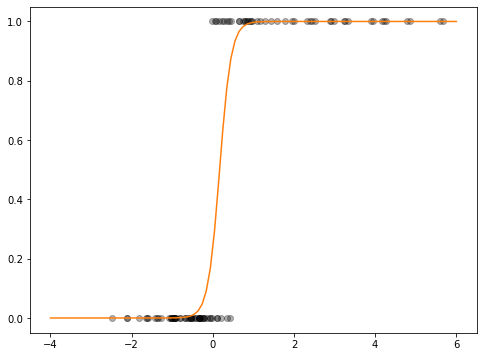

In [6]:
from scipy import optimize

def func(betas):
    """Partial derevatives of the log-likelihood."""
    b0 = betas[0]
    b1 = betas[1]
    x = X.squeeze()
    f1 = np.sum(y - expit(b0 + b1 * x))
    f2 = np.sum(x * y - x * expit(b0 + b1 * x))
    return [f1, f2]

betas = optimize.fsolve(func, [0, 0])
print("intercept: {}, slope: {}".format(betas[0], betas[1]))
y_test = expit(X_test * betas[1] + betas[0]).squeeze()

plt.scatter(X, y, alpha=0.3, color="k")
plt.plot(X_test, y_test, color=colors[1])
plt.show()

## Did you realize our result is different from Scikit's?
Recall the plots:

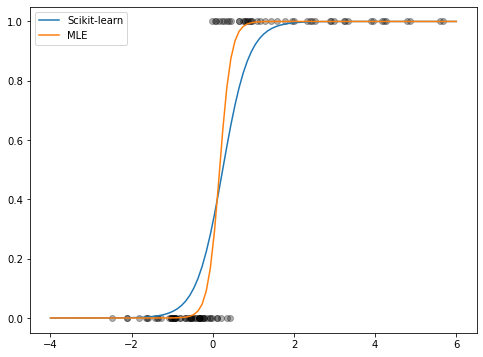

In [7]:
logreg = LogisticRegression().fit(X, y)
y_predict = expit(X_test * logreg.coef_ + logreg.intercept_).squeeze()
y_predict2 = expit(X_test * betas[1] + betas[0]).squeeze()

plt.scatter(X, y, alpha=0.3, color="k")
plt.plot(X_test, y_predict, color=colors[0], label='Scikit-learn')
plt.plot(X_test, y_predict2, color=colors[1], label='MLE')
plt.legend()
plt.show()


## Regularization

This discrepancy is due the regularization in scikit. By default, the `LogisticRegression()` class employs `L1` regularization.

If we remove the penalty, we will see the same result. 

(Note: I shifted the plot slightly next, so both of them are visible)

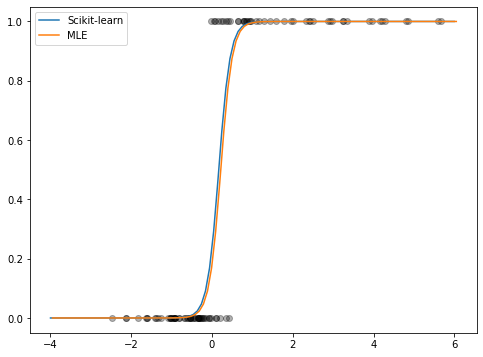

In [8]:
logreg = LogisticRegression(penalty='none').fit(X, y)

y_predict = expit(X_test * logreg.coef_ + logreg.intercept_).squeeze()
y_predict2 = expit(X_test * betas[1] + betas[0]).squeeze()

plt.scatter(X, y, alpha=0.3, color="k")
plt.plot(X_test, y_predict, color=colors[0], label='Scikit-learn')

# shift the plot for visualization
plt.plot(X_test+0.05, y_predict2, color=colors[1], label='MLE')
plt.legend()
plt.show()


# Pay attention to the model and prediction

The model is continuous, but the prediction output is either 0 or 1.

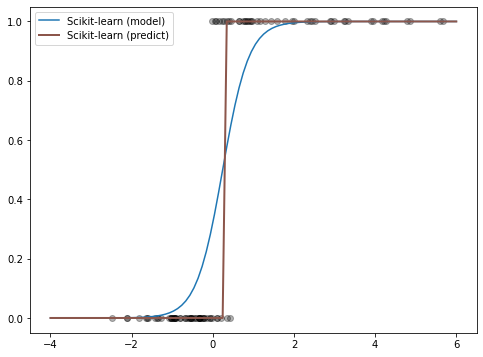

In [9]:
logreg = LogisticRegression().fit(X, y)

y_predict = expit(X_test * logreg.coef_ + logreg.intercept_).squeeze()
y_predict2 = logreg.predict(X_test.reshape(-1, 1))

plt.scatter(X, y, alpha=0.3, color="k")
plt.plot(X_test, y_predict, color=colors[0], label='Scikit-learn (model)')
plt.plot(X_test, y_predict2, color=colors[5], lw=2, label='Scikit-learn (predict)')

plt.legend()
plt.show()
